In [9]:
# general
import pandas as pd
import numpy as np
import quandl, math
import datetime

In [10]:
# Machine learning
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

In [11]:
# Visualize
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [12]:
# Quandl get info
quandl.ApiConfig.api_key = 'a-NjK8dK4_vxBJ6T7sqy'
df = quandl.get('WIKI/AAPL')

# Peek into data
print(df.head(2).round(1))
print('\n')

# Print columns, index
print(df.columns)
print(df.index)

            Open  High   Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                       
1980-12-12  28.8  28.9  28.8   28.8  2093900.0          0.0          1.0   
1980-12-15  27.4  27.4  27.2   27.2   785200.0          0.0          1.0   

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume  
Date                                                                 
1980-12-12        0.4        0.4       0.4         0.4  117258400.0  
1980-12-15        0.4        0.4       0.4         0.4   43971200.0  


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')
DatetimeIndex(['1980-12-12', '1980-12-15', '1980-12-16', '1980-12-17',
               '1980-12-18', '1980-12-19', '1980-12-22', '1980-12-23',
               '1980-12-24', '1980-12-26',
               ...
               '2018-03-14', '201

In [13]:
# Eliminate unneccesary features
df = df [['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

# New feature - high-low percentage
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / (df['Adj. Low'] * 100)

# New feature - percent change
df['PCT_CHNG'] = (df['Adj. Close'] - df['Adj. Open']) / (df['Adj. Open'] * 100)

df = df[['Adj. Close', 'HL_PCT', 'PCT_CHNG', 'Adj. Volume']]

In [14]:
print(df.head(1))

            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume
Date                                                   
1980-12-12    0.422706  0.000042       0.0  117258400.0


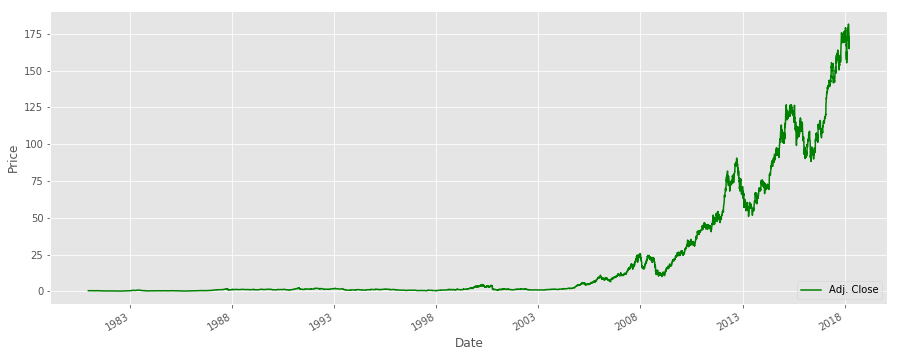

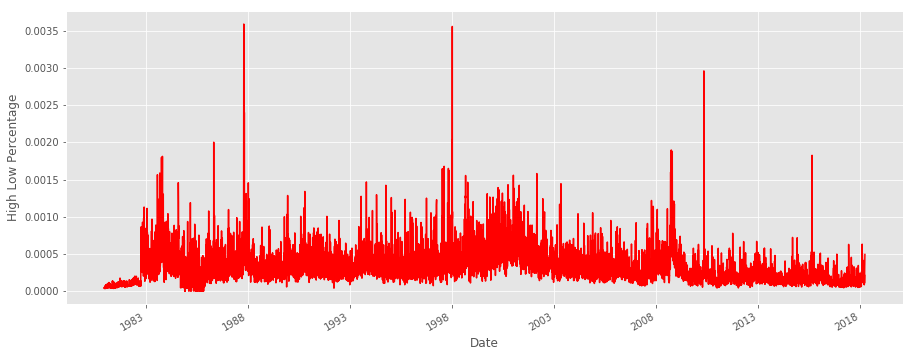

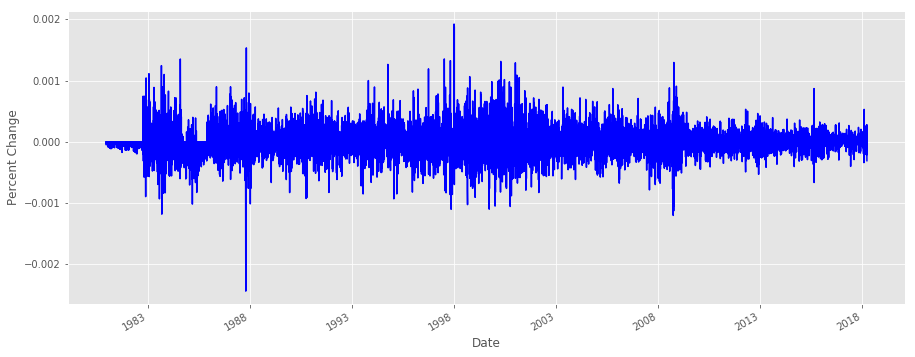

In [15]:
# Visualize

df['Adj. Close'].plot(figsize=(15,6), color="green")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

df['HL_PCT'].plot(figsize=(15,6), color="red")
plt.xlabel('Date')
plt.ylabel('High Low Percentage')
plt.show()

df['PCT_CHNG'].plot(figsize=(15,6), color="blue")
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.show()

In [16]:
# Forecasting on adjusted close
forecast_col = 'Adj. Close'

# Forecasting 30 days out- could adjust 
forecast_out = int(30)
print('length =', len(df), " and forecast_out =", forecast_out)

length = 9400  and forecast_out = 30


In [17]:
# Making the forecast row
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head(2))
print('\n')

#Check tail- it should have *forecast_out* rows with NaN
print(df.tail(2))

            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume     label
Date                                                             
1980-12-12    0.422706  0.000042  0.000000  117258400.0  0.470490
1980-12-15    0.400652  0.000048 -0.000047   43971200.0  0.455787


            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume  label
Date                                                          
2018-03-26      172.77  0.000400  0.000280   36272617.0    NaN
2018-03-27      168.34  0.000493 -0.000307   38962839.0    NaN


In [18]:
# Features matrix, drop label (to train)
X = np.array(df.drop(['label'], 1))

# What does this do? Normalizes the data
X = preprocessing.scale(X)
print(X[1,:])

[-0.53902357 -1.21945017 -0.18892951 -0.51273838]


c:\users\elija\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [19]:
# But X has those rows with NaN in for the label. Let's remove those
X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]

print("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))

Length of X_forecast_out: 30 & Length of X : 9370


In [20]:
# Now we need the Y to train it on. (check to make sure X, Y same length)

y = np.array(df['label'])
y = y[:-forecast_out]
print('Length of y: ', len(y))

Length of y:  9370


In [21]:
# Now we are cooking with fire. First, need to split for cross validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = .2)

print('Length of X_train and X_test: ', len(X_train), len(X_test))

Length of X_train and X_test:  7496 1874


In [22]:
# Train
clf = LinearRegression()
clf.fit(X_train, y_train)

# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.9925425392670176


In [30]:
# Make a quick benchmark- how good is this really?
# We will use the current closing price as our "guess"
baseline_x = np.array(df["Adj. Close"])
baseline_y = np.array(df["label"])

baseline_x = baseline_x[~np.isnan(baseline_x)]
baseline_y = baseline_y[~np.isnan(baseline_y)]

from sklearn.metrics import r2_score

print(r2_score(baseline_x, baseline_y))

# From the results, we can see this gives a small increase in prediction power

0.990622201868015


In [24]:
# Predict
forecast_prediction = clf.predict(X_forecast_out)
print(forecast_prediction)

[167.48299175 170.51351231 176.25631935 175.72248654 175.13921507
 174.3359222  175.9225691  178.93467533 182.37677429 181.81389925
 181.53157364 178.20497267 179.54426942 180.18689078 180.06984104
 178.41745428 180.34705809 183.42342525 185.20857441 183.3615029
 181.85262416 182.08425278 181.46316391 178.61951141 178.62304538
 174.51561489 172.03785483 168.02997811 175.94493671 171.38238536]


In [25]:
df.dropna(inplace=True)
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day



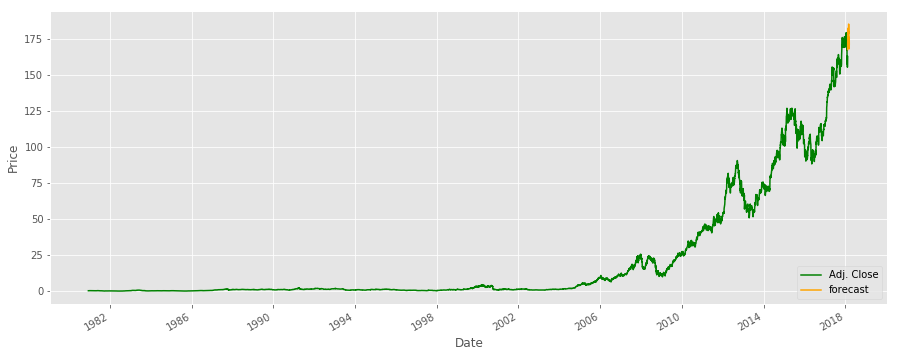

In [26]:
for i in forecast_prediction:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
    
df['Adj. Close'].plot(figsize=(15, 6), color="green")
df['forecast'].plot(figsize=(15, 6), color="orange")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

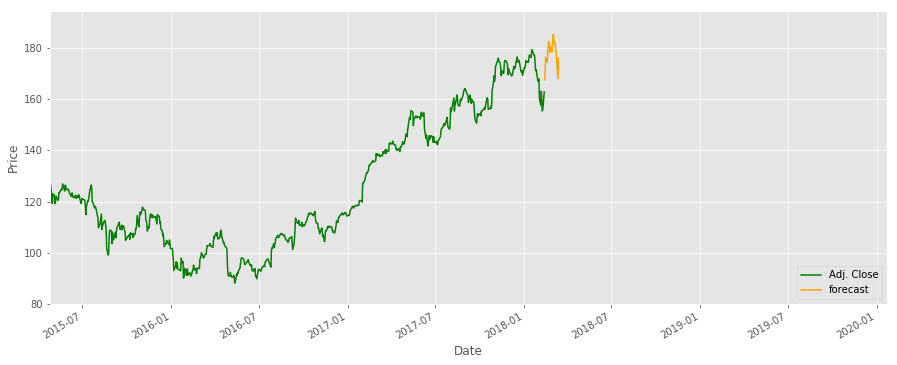

In [31]:
# Zoomed In to a year
df['Adj. Close'].plot(figsize=(15,6), color="green")
df['forecast'].plot(figsize=(15,6), color="orange")
plt.xlim(xmin=datetime.date(2015, 4, 26))
plt.ylim(ymin=80)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()